In [31]:
!pip install pydicom pillow pylibjpeg-libjpeg pylibjpeg python-gdcm seaborn matplotlib SciPy scikit-image python-magic tensorflow-io plotly pip install opencv-python tensorflow 

 

In [32]:
#%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
import pandas as pd
import cv2
import tensorflow as tf

In [33]:
#test_image = pydicom.read_file('train_images/10006/1459541791.dcm')
u = []
for s in glob("train_images/10006/*.dcm"):
    print("image file %s", s)
    img_test = pydicom.read_file(s)    
    u.append(img_test.pixel_array)
    #plt.imshow(img_test.pixel_array)
    print(img_test)


image file %s train_images/10006/1864590858.dcm
Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1864590858
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1864590858
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.986648'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.84

W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


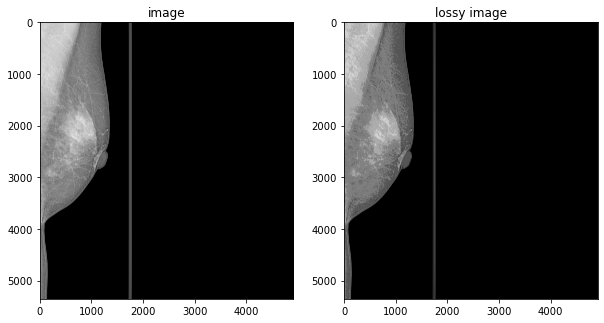

In [34]:
import tensorflow_io as tfio

image_bytes = tf.io.read_file('train_images/10006/1459541791.dcm')

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [35]:
tag_id = tfio.image.dicom_tags.PatientsAge
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(tag_value)

tf.Tensor(b'', shape=(), dtype=string)


W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


In [36]:
tag_id = tfio.image.dicom_tags.PatientsSex
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(f"PatientsSex : {tag_value.numpy().decode('UTF-8')}")

PatientsSex : 


W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


In [37]:
ls

rnsa_cnn_init.ipynb             test_images/
rnsa_cnn_preprocess_test.ipynb  train.csv
sample_submission.csv           train_images/
test.csv


In [38]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [39]:
train_df.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [40]:
train_df["cancer"][train_df["patient_id"] == 10006][0]

0

In [41]:
test_df.head()

site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id  
0       10008_L  
1       10008_L  
2       10008_R  
3       10008_R

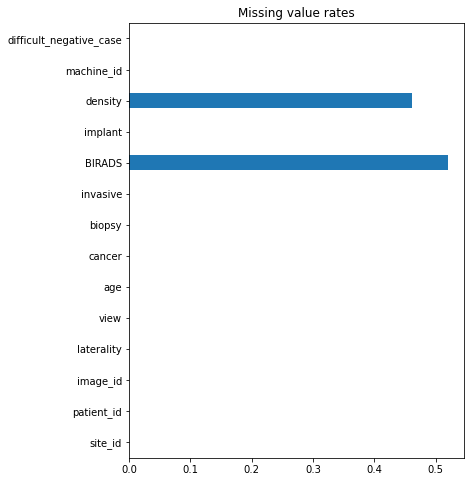

In [42]:
plt.figure(figsize=(6, 8))
train_df.isna().mean().plot(kind="barh")
plt.title("Missing value rates");

In [43]:
test_df.nunique()

site_id          1
patient_id       1
image_id         4
laterality       2
view             2
age              1
implant          1
machine_id       1
prediction_id    2
dtype: int64

In [44]:
train_images = glob("train_images/*/*.dcm")
len(train_images)

54706

In [45]:
train_images[0]

'train_images/1069/1313414003.dcm'

In [46]:
train_image0 = pydicom.read_file(train_images[0])
print(train_image0)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184021.071147'
(0010, 0020) Patient ID                          LO: '1069'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.1069
(0020, 000e) Series Instance UID

In [47]:
train_image0_array = train_image0.pixel_array

In [48]:
print(train_image0_array)

[[1784 1760 1686 ...    0    0    0]
 [1687 1754 1732 ...    0    0    0]
 [1682 1687 1736 ...    0    0    0]
 ...
 [1040 1043 1044 ...    0    0    0]
 [1034 1041 1059 ...    0    0    0]
 [1070 1059 1070 ...    0    0    0]]


In [49]:
print(train_image0_array.shape)

(2776, 2082)


0
2342


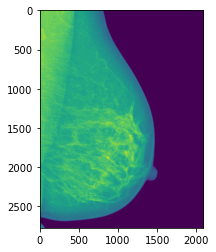

In [50]:
plt.imshow(train_image0_array)
print(train_image0_array.min())
print(train_image0_array.max())

In [51]:
# cf https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606
# Five steps of preprocessing: 
# Transforming to HU, Removing Noises, Tilt Correction, Crop Images and Padding.
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [52]:
from scipy import ndimage

In [53]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    # I am not sure why some scans have multiple window_center values while some have only one
    # So naively I just take the average of their values
    # TODO: to better understand the mammography images...
    window_center = np.array(medical_image.WindowCenter).mean()
    window_width = np.array(medical_image.WindowWidth).mean()
    windowed_image = window_image(hu_image, window_center, window_width) 
    
    segmentation = morphology.dilation(windowed_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * windowed_image
    return masked_image

In [54]:
file_path = "train_images/10006/1459541791.dcm"
medical_image = pydicom.read_file(file_path)
image = medical_image.pixel_array

#hu_image = transform_to_hu(medical_image, image)
#window_center = medical_image.WindowCenter
#window_width = medical_image.WindowWidth
#windowed_image = window_image(hu_image, window_center, window_width) 
np.array(medical_image.WindowCenter)[0].mean()

1802.31

In [55]:
# for tilt correction
# not sure if it is useful for breast cancer as the original data is for brain ct
# tbd

In [56]:
def crop_image(image, display = False):
    mask = image == 0
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis = 1)
    bottom_right = np.max(coords, axis = 1)
    cropped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return cropped_image

In [57]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [58]:
hu_image = transform_to_hu( train_image0, train_image0_array)
windowed_image0 = window_image(hu_image, train_image0.WindowCenter, train_image0.WindowWidth)

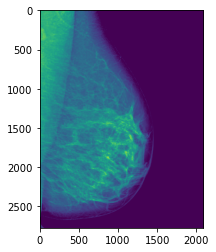

In [59]:
plt.imshow(windowed_image0)

In [60]:
#file_path = "train_images/10006/1459541791.dcm"
removed_noise_image0 = remove_noise("train_images/10006/1459541791.dcm", display = False)
#removed_noise_image0 = remove_noise(patient_all_files[0])

/var/folders/vn/7vh0yxsj5js3z8lj0p09cq1w0000gn/T/ipykernel_89384/1123072781.py:16: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [61]:
cropped_image0 = crop_image(removed_noise_image0)

In [62]:
cropped_image0.shape

(5354, 4914)

In [63]:
# added_pad_image0 = add_pad(cropped_image0)

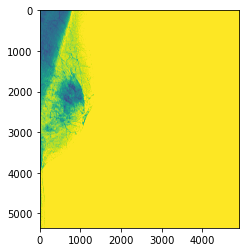

In [64]:
plt.imshow(cropped_image0)

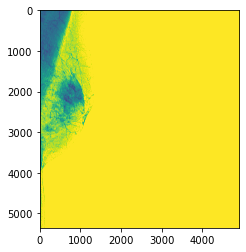

In [65]:
plt.imshow(removed_noise_image0)

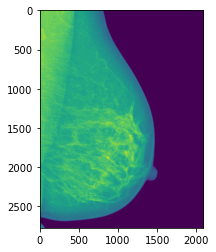

In [66]:
plt.imshow(train_image0_array)

In [67]:
# wrap the above functions up into one master func
def preprocess_dicom(file):
    removed_noise_image0 = remove_noise(file, display = False)
    cropped_image = crop_image(removed_noise_image0)
    return cropped_image

In [70]:
if_patient_in_train_csv = []
all_patients = os.listdir("train_images/")
for patient in all_patients:
    if patient not in str(train_df["patient_id"]):
        if_patient_in_train_csv.append(False)
    else:
        if_patient_in_train_csv.append(True)
            

In [71]:
if_patient_not_in_train_csv = [not x for x in if_patient_in_train_csv]
patient_in_train_csv = np.array(all_patients)[if_patient_in_train_csv]
patients_not_in_train_csv = np.array(all_patients)[if_patient_not_in_train_csv]

In [72]:
print("patient ids as image file folder matched up with train_df.csv :", patient_in_train_csv, "the matched ids in total", patient_in_train_csv.shape[0])

patient ids as image file folder matched up with train_df.csv : ['997' '10006' '54701' '703' '9989' '9973' '547' '10011' '4706' '5'
 '54704'] the matched ids in total 11


In [73]:
print("patient ids not matched in the image folder and train_df.csv: ", patients_not_in_train_csv, "the not matched ids in total", patients_not_in_train_csv.shape[0])

patient ids not matched in the image folder and train_df.csv:  ['1069' '48123' '19781' ... '54351' '986' '46694'] the not matched ids in total 11902


In [74]:
# load the data
y = []
X = []
### WARNING: temporary solution. to only get the matched data trained
for patient in patient_in_train_csv:
    patient_all_files = glob("train_images/"+ patient + "/*.dcm")
    for patient_file in patient_all_files:        
        patient_array = preprocess_dicom(patient_file)
        X.append(patient_array)

/var/folders/vn/7vh0yxsj5js3z8lj0p09cq1w0000gn/T/ipykernel_89384/1123072781.py:16: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
#train_df['cancer'][train_df["patient_id"].astype(str) == (patient_in_train_csv[0])].unique()


In [75]:
#print(patient_in_train_csv)
#train_df.loc[train_df['patient_id'].astype(str).isin(patient_in_train_csv)]        
#y_patient = train_df["cancer"][str(train_df["patient_id"]) == patient][0]
#y.append(y_patient)
for patient in patient_in_train_csv:
    patient_all_files = glob("train_images/"+ patient + "/*.dcm")
    for patient_file in patient_all_files:  
        y_tmp = train_df['cancer'][train_df["patient_id"].astype(str) == (patient_in_train_csv[0])].unique()
        y.append(y_tmp)

In [76]:
X_array = np.array(X)
y_array = np.array(y)
print(X_array.shape)
print(y_array.shape)

(47,)
(47, 1)


/var/folders/vn/7vh0yxsj5js3z8lj0p09cq1w0000gn/T/ipykernel_89384/2311208697.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [77]:
# naively split the train and test data
# using the train test split function
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_array,y_array ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)

In [78]:
# resize features
img_size = 224 # not sure why. but copy from https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
X_train_resize = []
X_val_resize = []
for x in X_train:
    resized_arr = cv2.resize(x, (img_size, img_size)) # Reshaping images to preferred size
    X_train_resize.append(resized_arr)
for x in X_val:
    resized_arr = cv2.resize(x, (img_size, img_size)) # Reshaping images to preferred size
    X_val_resize.append(resized_arr)

In [79]:
# normalize data
X_train = np.array(X_train_resize)/255 # not sure why but naively use the online code from https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
X_train = X_train.reshape(-1, img_size, img_size, 1)

X_val = np.array(X_val_resize)/255 # not sure why but naively use the online code from https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
X_val = X_val.reshape(-1, img_size, img_size, 1)


In [80]:
X_train.shape

(35, 224, 224, 1)

In [81]:
X_train.shape
X_val.shape

(12, 224, 224, 1)

In [82]:
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

In [83]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [87]:
# define model
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [88]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [89]:
history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_val, y_val))

Epoch 1/500


/Users/xueweichen/Downloads/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



2/2 [==============================] - 2s 387ms/step - loss: 0.6182 - accuracy: 0.7143 - val_loss: 0.5302 - val_accuracy: 0.9167
Epoch 2/500
2/2 [==============================] - 1s 203ms/step - loss: 0.5038 - accuracy: 0.7429 - val_loss: 0.4329 - val_accuracy: 0.9167
Epoch 3/500
2/2 [==============================] - 1s 194ms/step - loss: 0.4730 - accuracy: 0.7429 - val_loss: 0.3512 - val_accuracy: 1.0000
Epoch 4/500
2/2 [==============================] - 1s 194ms/step - loss: 0.3987 - accuracy: 0.8571 - val_loss: 0.2844 - val_accuracy: 1.0000
Epoch 5/500
2/2 [==============================] - 1s 181ms/step - loss: 0.2766 - accuracy: 0.9714 - val_loss: 0.2323 - val_accuracy: 1.0000
Epoch 6/500
2/2 [==============================] - 1s 179ms/step - loss: 0.2591 - accuracy: 1.0000 - val_loss: 0.1917 - val_accuracy: 1.0000
Epoch 7/500
2/2 [==============================] - 1s 182ms/step - loss: 0.2090 - accuracy: 1.0000 - val_loss: 0.1595 - val_accuracy: 1.0000
Epoch 8/500
2/2 [========

Epoch 59/500
2/2 [==============================] - 1s 316ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 60/500
2/2 [==============================] - 1s 248ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 61/500
2/2 [==============================] - 1s 239ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 62/500
2/2 [==============================] - 1s 187ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 63/500
2/2 [==============================] - 1s 192ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 64/500
2/2 [==============================] - 1s 190ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 65/500
2/2 [==============================] - 1s 181ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 

2/2 [==============================] - 1s 223ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 117/500
2/2 [==============================] - 1s 211ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 118/500
2/2 [==============================] - 1s 235ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 119/500
2/2 [==============================] - 1s 230ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 120/500
2/2 [==============================] - 1s 219ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 121/500
2/2 [==============================] - 1s 213ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 122/500
2/2 [==============================] - 1s 203ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 123/500

2/2 [==============================] - 1s 198ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 174/500
2/2 [==============================] - 1s 192ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 175/500
2/2 [==============================] - 1s 186ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 176/500
2/2 [==============================] - 1s 190ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 177/500
2/2 [==============================] - 1s 187ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 178/500
2/2 [==============================] - 1s 182ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 179/500
2/2 [==============================] - 1s 195ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 180/500

Epoch 230/500
2/2 [==============================] - 1s 192ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.3549e-04 - val_accuracy: 1.0000
Epoch 231/500
2/2 [==============================] - 1s 201ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.2816e-04 - val_accuracy: 1.0000
Epoch 232/500
2/2 [==============================] - 1s 194ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.2051e-04 - val_accuracy: 1.0000
Epoch 233/500
2/2 [==============================] - 1s 187ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.1334e-04 - val_accuracy: 1.0000
Epoch 234/500
2/2 [==============================] - 1s 193ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 8.0631e-04 - val_accuracy: 1.0000
Epoch 235/500
2/2 [==============================] - 1s 195ms/step - loss: 9.4589e-04 - accuracy: 1.0000 - val_loss: 7.9965e-04 - val_accuracy: 1.0000
Epoch 236/500
2/2 [==============================] - 1s 189ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7

2/2 [==============================] - 1s 194ms/step - loss: 7.7900e-04 - accuracy: 1.0000 - val_loss: 5.3836e-04 - val_accuracy: 1.0000
Epoch 286/500
2/2 [==============================] - 1s 188ms/step - loss: 7.7801e-04 - accuracy: 1.0000 - val_loss: 5.3515e-04 - val_accuracy: 1.0000
Epoch 287/500
2/2 [==============================] - 1s 186ms/step - loss: 5.9189e-04 - accuracy: 1.0000 - val_loss: 5.3219e-04 - val_accuracy: 1.0000
Epoch 288/500
2/2 [==============================] - 1s 185ms/step - loss: 6.8832e-04 - accuracy: 1.0000 - val_loss: 5.2920e-04 - val_accuracy: 1.0000
Epoch 289/500
2/2 [==============================] - 1s 196ms/step - loss: 8.6915e-04 - accuracy: 1.0000 - val_loss: 5.2581e-04 - val_accuracy: 1.0000
Epoch 290/500
2/2 [==============================] - 1s 187ms/step - loss: 8.3070e-04 - accuracy: 1.0000 - val_loss: 5.2226e-04 - val_accuracy: 1.0000
Epoch 291/500
2/2 [==============================] - 1s 186ms/step - loss: 0.0011 - accuracy: 1.0000 - val_l

2/2 [==============================] - 1s 183ms/step - loss: 5.3297e-04 - accuracy: 1.0000 - val_loss: 3.8430e-04 - val_accuracy: 1.0000
Epoch 340/500
2/2 [==============================] - 1s 193ms/step - loss: 6.3298e-04 - accuracy: 1.0000 - val_loss: 3.8196e-04 - val_accuracy: 1.0000
Epoch 341/500
2/2 [==============================] - 1s 188ms/step - loss: 7.5381e-04 - accuracy: 1.0000 - val_loss: 3.7964e-04 - val_accuracy: 1.0000
Epoch 342/500
2/2 [==============================] - 1s 199ms/step - loss: 6.6097e-04 - accuracy: 1.0000 - val_loss: 3.7721e-04 - val_accuracy: 1.0000
Epoch 343/500
2/2 [==============================] - 1s 240ms/step - loss: 5.0761e-04 - accuracy: 1.0000 - val_loss: 3.7483e-04 - val_accuracy: 1.0000
Epoch 344/500
2/2 [==============================] - 1s 219ms/step - loss: 7.3770e-04 - accuracy: 1.0000 - val_loss: 3.7254e-04 - val_accuracy: 1.0000
Epoch 345/500
2/2 [==============================] - 1s 202ms/step - loss: 4.5432e-04 - accuracy: 1.0000 - v

2/2 [==============================] - 1s 195ms/step - loss: 3.6815e-04 - accuracy: 1.0000 - val_loss: 2.8376e-04 - val_accuracy: 1.0000
Epoch 394/500
2/2 [==============================] - 1s 194ms/step - loss: 4.6805e-04 - accuracy: 1.0000 - val_loss: 2.8263e-04 - val_accuracy: 1.0000
Epoch 395/500
2/2 [==============================] - 1s 190ms/step - loss: 5.1542e-04 - accuracy: 1.0000 - val_loss: 2.8154e-04 - val_accuracy: 1.0000
Epoch 396/500
2/2 [==============================] - 1s 198ms/step - loss: 4.9038e-04 - accuracy: 1.0000 - val_loss: 2.8051e-04 - val_accuracy: 1.0000
Epoch 397/500
2/2 [==============================] - 1s 195ms/step - loss: 3.8600e-04 - accuracy: 1.0000 - val_loss: 2.7955e-04 - val_accuracy: 1.0000
Epoch 398/500
2/2 [==============================] - 1s 190ms/step - loss: 4.8771e-04 - accuracy: 1.0000 - val_loss: 2.7860e-04 - val_accuracy: 1.0000
Epoch 399/500
2/2 [==============================] - 1s 192ms/step - loss: 5.2293e-04 - accuracy: 1.0000 - v

2/2 [==============================] - 1s 194ms/step - loss: 4.1692e-04 - accuracy: 1.0000 - val_loss: 2.2473e-04 - val_accuracy: 1.0000
Epoch 448/500
2/2 [==============================] - 1s 190ms/step - loss: 2.9567e-04 - accuracy: 1.0000 - val_loss: 2.2392e-04 - val_accuracy: 1.0000
Epoch 449/500
2/2 [==============================] - 1s 193ms/step - loss: 5.2010e-04 - accuracy: 1.0000 - val_loss: 2.2298e-04 - val_accuracy: 1.0000
Epoch 450/500
2/2 [==============================] - 1s 184ms/step - loss: 4.2981e-04 - accuracy: 1.0000 - val_loss: 2.2192e-04 - val_accuracy: 1.0000
Epoch 451/500
2/2 [==============================] - 1s 214ms/step - loss: 2.6893e-04 - accuracy: 1.0000 - val_loss: 2.2101e-04 - val_accuracy: 1.0000
Epoch 452/500
2/2 [==============================] - 1s 207ms/step - loss: 3.7837e-04 - accuracy: 1.0000 - val_loss: 2.2015e-04 - val_accuracy: 1.0000
Epoch 453/500
2/2 [==============================] - 1s 198ms/step - loss: 4.3748e-04 - accuracy: 1.0000 - v

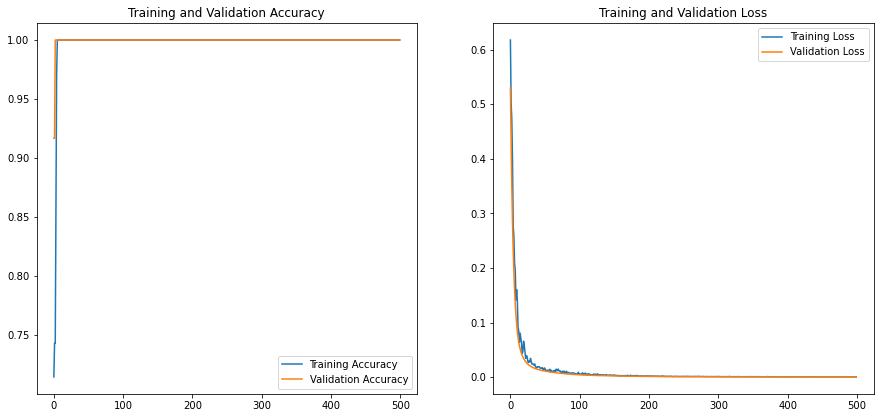

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [109]:
predictions_x = model.predict(X_val)
predictions=np.argmax(predictions_x,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Non-cancer (Class 0)']))


1/1 [==============================] - 0s 130ms/step
                      precision    recall  f1-score   support

Non-cancer (Class 0)       1.00      1.00      1.00        12

            accuracy                           1.00        12
           macro avg       1.00      1.00      1.00        12
        weighted avg       1.00      1.00      1.00        12

